# Deep Learning Development Pipeline
---

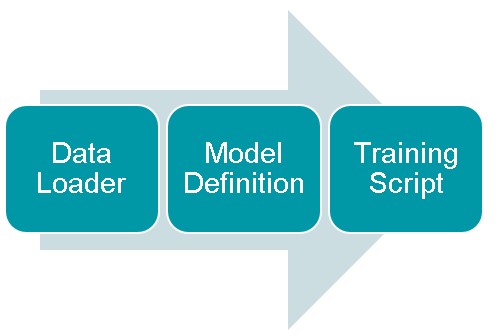

- It is officially recommended that Keras sequence class need to be used for DataLoader implementation.
- This is because it is more appropriate to utilize multi-processing when it comes to Keras sequence class.

## 1. DataLoader: Sequence Class Example (Official Guide)

Example from https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

```python
class CIFAR10Sequence(Sequence):
    
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_szie:(idx + 1) *
                        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
                        self.batch_size]
        
        return np.array([
            resize(imread(file_name), (200, 200))
                for file_name in batch_x]), np.array(batch_y)
```

- `__len__`: Number of batch in the Sequence
- `__getitem__`: Returns a complete batch.
- `on_epoch_end` (optional): Modifies dataset between epochs.

In [ ]:
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

In [ ]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, batch_size, csv_path, fold,
                 image_size, mode = 'train', shuffle = True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        self.on_epoch_end()
        
    # the number of batches
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    
    def get_data(self, data):
        
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            # B - R reversal
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # resizing images
            image = cv2.resize(image, (self.image_size, self.image_size))
            # rescaling
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
            
        return batch_x, batch_y
    
    # callback function
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac = 1).reset_index(drop = True)

In [ ]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    batch_size = 9,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
    )

In [ ]:
# checking 'len' method
print(len(train_generator))
print(654 * 9) # 9: batch_size
               # training data: 80%

In [ ]:
# checking whether or not data is properly loaded
class_name = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize = (15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    
    break

## 2. Model Definition 1 - Sequential Class

Sequential class example
\
From https://www.tensorflow.org/guid/keras/sequential_model

```python
# Define Sequential model with 3 layers.
model = keras.Sequential(
    [
        layers.Dense(2, activation = 'relu', name = 'layer1'),
        layers.Dense(3, activation = 'relu', name = 'layer2'),
        layers.Dense(4, name = 'layer3'),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)
```

A Sequential model is not appropriate when:
- Your model has multiple inputs or multiple outputs.
- Any of your layers has multiple inputs or multiple outputs.
- You need to do layer sharing.
- You want non-linear topology (e.g. a residual connection, a multi-branch model)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
def get_sequential_model(input_shape):
    
    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),
            
            # the 1st Conv block (a series of layers)
            # 64 (# of filters) / 3 (kernel size)
            layers.Conv2D(64, 3, strides = 1, activation = 'relu',
                         padding = 'same'),
            layers.Conv2D(64, 3, strides = 1, activation = 'relu',
                         padding = 'same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # the 2nd Conv block
            layers.Conv2D(128, 3, strides = 1, activation = 'relu',
                         padding = 'same'),
            layers.Conv2D(128, 3, strides = 1, activation = 'relu',
                         padding = 'same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            # Classifier block
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation = 'relu'),
            layers.Dense(1, activation = 'sigmoid')
        ]
    )
    
    return model

In [ ]:
# checking model definition
input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.summary()

## 2. Model Definition 2 - Functional Approach

In [ ]:
# No restrictions in contrast to Sequntial Class approach
# It is the same as Sequential Class approach in that
# users have to set input tensor.
# Users must store the results from every layer and
# deliver them to the subsequent layer manually.
def get_functional_model(input_shape):
    inputs = keras.Input(input_shape)
    
    # the 1st Conv block
    x = layers.Conv2D(64, 3, strides = 1, activation = 'relu',
                      padding = 'same')(inputs)
    x = layers.Conv2D(64, 3, strides = 1, activation = 'relu',
                      padding = 'same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # the 2nd Conv block
    x = layers.Conv2D(128, 3, strides = 1, activation = 'relu',
                      padding = 'same')(x)
    x = layers.Conv2D(128, 3, strides = 1, activation = 'relu',
                      padding = 'same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Classifier block
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Dense(128, activation = 'relu')(x)
    outputs = layers.Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

In [ ]:
input_shape = (256, 256, 3)
model = get_functional_model(input_shape)

model.summary()

## 2. Model Definition 3 - Model Subclassing

- It exposes built-in training, evaluation, and prediction loops `(model.fit(), model.evaluate(), model.predict())`.
- It exposes the list of its inner layers, via the model.layers property.
- It exposes saving and serialization APIs `(save(), save_weights()`...).

In [ ]:
class SimpleCNN(keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # the 1st conv block
        self.conv_block_1 = keras.Sequential(
            [
                layers.Conv2D(64, 3, strides = 1, activation = 'relu',
                             padding = 'same'),
                layers.Conv2D(64, 3, strides = 1, activation = 'relu',
                             padding = 'same'),
                layers.MaxPool2D(),
                layers.BatchNormalization(),
                layers.Dropout(0.5)
            ], name = 'conv_block_1'
        )
        
        # the 2nd conv block
        self.conv_block_2 = keras.Sequential(
            [
                layers.Conv2D(128, 3, strides = 1, activation = 'relu',
                             padding = 'same'),
                layers.Conv2D(128, 3, strides = 1, activation = 'relu',
                             padding = 'same'),
                layers.MaxPool2D(),
                layers.BatchNormalization(),
                layers.Dropout(0.3)                
            ], name = 'conv_block_2'
        )
        
        # Classifier block
        self.classifier = keras.Sequential(
            [
                layers.GlobalMaxPool2D(),
                layers.Dense(128, activation = 'relu'),
                layers.Dense(1, activation = 'sigmoid')
            ], name = 'classifier'
        )
    
    # training flag: to differently designate instructions
    # such as dropout or batchnormalization
    # whether a dataset is training or test
    def call(self, input_tensor, training = False):
        x = self.conv_block_1(input_tensor)
        x = self.conv_block_2(x)
        return self.classifier(x)

In [ ]:
input_shape = (None, 256, 256, 3) # None: batch axis
model = SimpleCNN()
# due to absence of input layer definition in the above cell...
model.build(input_shape)

model.summary()

### Model Compiling

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

## 3. Training Script

In [ ]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

There exist some errors when reading Oxford-IIT Pets Data.

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode = 'train', shuffle = True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]

        #### Remove invalid files.
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_144',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191'
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[-self.df['file_name']. \
                        isin(invalid_filenames)]
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
            
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac = 1).reset_index(drop = True)

In [ ]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold = 1,
    mode = 'train',
    csv_path = csv_path,
    batch_size = 128,
    image_size = 256,
    shuffle = True)

valid_generator = DataGenerator(
    fold = 1,
    mode = 'val',
    csv_path = csv_path,
    batch_size = 128,
    image_size = 256,
    shuffle = True)

## Callback Functions

The functions which are called in particular situations...

```python
callbacks = tf.keras.callbacks.CallbackList([...])
callbacks.append(...)

callbacks.on_train_begin(...)
for epoch in range(EPOCHS):
    calbacks.on_epoch_begin(epoch)
    for i, data in dataset.enumerate():
        callbacks.on_train_batch_begin(i)
        batch_logs = model.train_step(data)
        callbacks.on_train_batch_end(i, batch_logs)
    epoch_logs = ...
    callbacks.on_epoch_end(epoch, epoch_logs)
final_logs = ...
callbacks.on_train_end(final_logs)
```

Typical Callback Functions
- `on_train_begin`
- `on_epoch_begin`
- `on_train_batch_begin`
- `on_train_batch_end`
- `on_epoch_end`


- `keras.Model.fit()`
- `keras.Model.evaluate()`
- `keras.Model.predict()`

In [ ]:
# Callback function example 1
# EarlyStopping: stops training if performance is not improved any more
# for given epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 3, verbose = 1,
    mode = 'min', restore_best_weights = False
)


In [ ]:
# Callback function example 2
# ReduceLROnPlateau: reduces a learning rate if performance is not
# improved any more for given epochs. (a sort of learning rate scheduler)
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.1, patience = 10, verbose = 1,
    mode = 'min', min_lr = 0.001
)

In [ ]:
# Callback function example 3
# ModelCheckpoint: saves a model.
filepath = '{epoch:02d} - {val_loss:.2f}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor = 'val_loss', verbose = 1, save_best_only = True,
    save_weights_only = False, mode = 'min') # save_weights_only = False
                                             # -> saving including
                                             # a model structure

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    callbacks = [
        early_stopping,
        reduce_on_plateau,
        model_checkpoint
    ],
    verbose = 1
)

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label = 'train')
plt.plot(history['val_accuracy'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()